KiraCat

In [ ]:
#instalar liberías necesarias
!pip install ultralytics

In [ ]:
#montar drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Configuraciones
# Directorios de origen
root_dir = "drive/MyDrive/Archivos/PCBData"
input_images_dir = f"{root_dir}/images_originales"  # Directorio con archivos de imágenes
input_annotations_dir = f"{root_dir}/labels_originales"  # Directorio con archivos de anotaciones
labels_dir = f"{root_dir}/labels_yolo"   # Carpeta donde guardar las anotaciones convertidas

# Directorios de destino
root_target_dataset = "/content/datasets"
train_images_dir = f"{root_target_dataset}/images/train"
val_images_dir = f"{root_target_dataset}/images/val"
train_labels_dir = f"{root_target_dataset}/labels/train"
val_labels_dir = f"{root_target_dataset}/labels/val"

# Archivo de configuración YOLO
settings_yolo = f"{root_target_dataset}/pcb.yaml"

#archivo final del modelo
modelfile = f"{root_dir}/kiracat.pt"


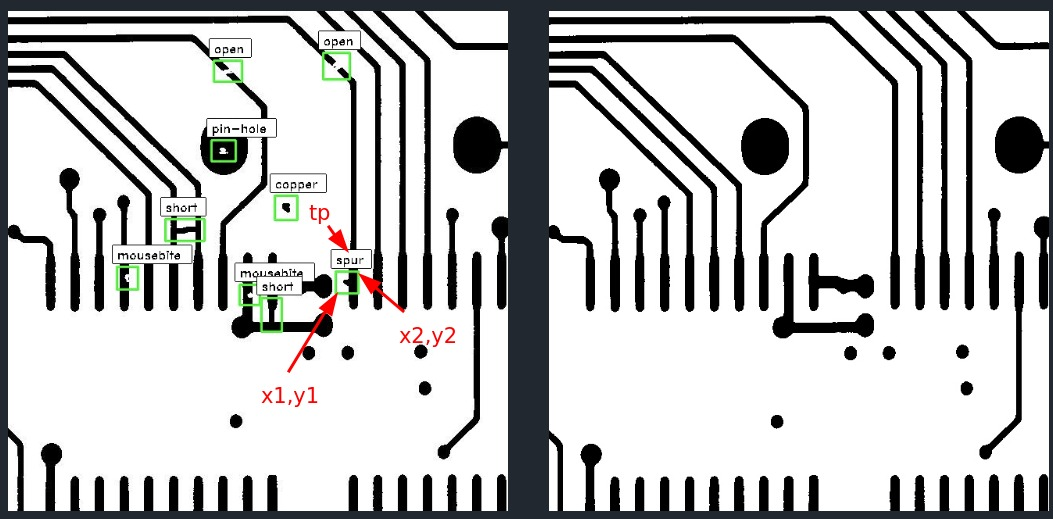

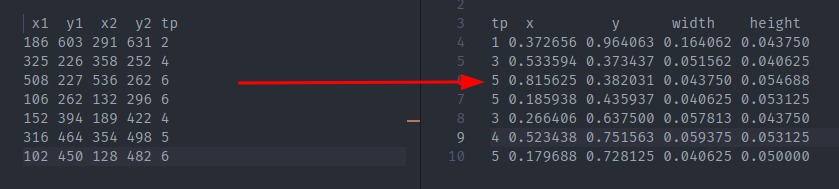

In [ ]:
#convertir las anotaciones al formato YOLO

import os

# Configuración

image_width, image_height = 640, 640          # Dimensiones de las imágenes

# Crear la carpeta de salida si no existe
os.makedirs(labels_dir, exist_ok=True)

# Procesar cada archivo de anotaciones
for filename in os.listdir(input_annotations_dir):
    if filename.endswith(".txt"):  # Asegurar que es un archivo de texto
        input_path = os.path.join(input_annotations_dir, filename)
        output_path = os.path.join(labels_dir, filename.replace('.txt','_test.txt'))

        with open(input_path, "r") as infile, open(output_path, "w") as outfile:
            for line in infile:
                x1, y1, x2, y2, class_id = line.strip().split()

                # Convertir a enteros
                x1, y1, x2, y2, class_id = int(x1), int(y1), int(x2), int(y2), int(class_id)

                class_id = class_id - 1 #YOLO usa clasificación de 0 - N

                # Convertir a formato YOLO
                x_center = (x1 + x2) / 2.0 / image_width
                y_center = (y1 + y2) / 2.0 / image_height
                width = (x2 - x1) / image_width
                height = (y2 - y1) / image_height

                # Guardar en el nuevo archivo
                outfile.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print("Conversión completada. Anotaciones guardadas en:", labels_dir)



In [ ]:
#generar anotaciones en blanco para la imágenes sin fallos.
def createEmptyAnnotationFile(ruta):
  for filename in os.listdir(ruta):
    if(filename.endswith("_temp.jpg")):
      emptyFile = f"{labels_dir}/{filename.replace('.jpg','.txt')}";
      with open(emptyFile, 'w') as fp:
        pass

createEmptyAnnotationFile(input_images_dir)

In [ ]:
#verificar la cantidad de imagenes origen vs las cantidad de anotaciones
print(f"📊 Imágenes de originales: {len(os.listdir(input_images_dir))}, Anotaciones YOLO: {len(os.listdir(labels_dir))}")


In [ ]:
#separar dataset
import os
import shutil
import random

# Crear carpetas si no existen
for d in [train_images_dir, val_images_dir, train_labels_dir, val_labels_dir]:
    os.makedirs(d, exist_ok=True)

# Obtener lista de imágenes
images = [f for f in os.listdir(input_images_dir) if f.endswith(".jpg")]
random.shuffle(images)  # Mezclar aleatoriamente

# Definir el split 80-20
split_idx = int(0.8 * len(images))
train_images = images[:split_idx]
val_images = images[split_idx:]

# Función para copiar archivos
def copy_files(file_list, source_img, source_lbl, dest_img, dest_lbl):
    for img in file_list:
        base_name = os.path.splitext(img)[0]
        img_path = os.path.join(source_img, img)
        lbl_path = os.path.join(source_lbl, base_name + ".txt")

        shutil.copy(img_path, dest_img)
        if os.path.exists(lbl_path):  # Asegurar que haya anotación
            shutil.copy(lbl_path, dest_lbl)

# Copiar los archivos
copy_files(train_images, input_images_dir, labels_dir, train_images_dir, train_labels_dir)
copy_files(val_images, input_images_dir, labels_dir, val_images_dir, val_labels_dir)

print("✅ División completada: 80% entrenamiento, 20% validación.")

# verificar los datasets
train_images = len(os.listdir(train_images_dir))
val_images = len(os.listdir(val_images_dir))
train_labels = len(os.listdir(train_labels_dir))
val_labels = len(os.listdir(val_labels_dir))

print(f"📊 Imágenes de entrenamiento: {train_images}, Anotaciones: {train_labels}")
print(f"📊 Imágenes de validación: {val_images}, Anotaciones: {val_labels}")


In [ ]:
#copiar el archivo de configuración para YOLOv8
shutil.copy(f"{root_dir}/pcb.yaml",f"{root_target_dataset}/pcb.yaml")

In [ ]:
from ultralytics import YOLO

# Cargar el modelo preentrenado (YOLOv8 nano para empezar)
model = YOLO("yolov8n.pt")
model.train(data=settings_yolo, epochs=10, imgsz=640, batch=16)
model.save(modelfile)

100%|██████████| 6.25M/6.25M [00:00<00:00, 264MB/s]

Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=/content/datasets/pcb.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes

100%|██████████| 755k/755k [00:00<00:00, 90.9MB/s]


Overriding model.yaml nc=80 with nc=6

                   from  n    params  module                                       arguments                     
  0                  -1  1       464  ultralytics.nn.modules.conv.Conv             [3, 16, 3, 2]                 
  1                  -1  1      4672  ultralytics.nn.modules.conv.Conv             [16, 32, 3, 2]                
  2                  -1  1      7360  ultralytics.nn.modules.block.C2f             [32, 32, 1, True]             
  3                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  4                  -1  2     49664  ultralytics.nn.modules.block.C2f             [64, 64, 2, True]             
  5                  -1  1     73984  ultralytics.nn.modules.conv.Conv             [64, 128, 3, 2]               
  6                  -1  2    197632  ultralytics.nn.modules.block.C2f             [128, 128, 2, True]           
  7                  -1  1    295424  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 219MB/s]


AMP: checks passed ✅


train: Scanning /content/datasets/labels/train... 2400 images, 1187 backgrounds, 0 corrupt: 100%|██████████| 2400/2400 [00:00<00:00, 2748.52it/s]


train: New cache created: /content/datasets/labels/train.cache
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))


val: Scanning /content/datasets/labels/val... 601 images, 314 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<00:00, 767.30it/s]


val: New cache created: /content/datasets/labels/val.cache
Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1.0, 4.0), tile_grid_size=(8, 8))

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.06G      2.087      3.638      1.376         55        640: 100%|██████████| 150/150 [01:03<00:00,  2.35it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:11<00:00,  1.63it/s]

                   all        601       1875      0.589      0.622        0.6      0.359



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.03G      1.398      1.894      1.066         83        640: 100%|██████████| 150/150 [00:53<00:00,  2.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.03it/s]


                   all        601       1875      0.734      0.704       0.79      0.427

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.03G      1.288       1.44      1.036         60        640: 100%|██████████| 150/150 [00:55<00:00,  2.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.49it/s]

                   all        601       1875      0.882      0.818      0.902       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.01G       1.27      1.228      1.021         48        640: 100%|██████████| 150/150 [00:46<00:00,  3.23it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.04it/s]


                   all        601       1875      0.908      0.845      0.928      0.611

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10         2G      1.166      1.036     0.9927         60        640: 100%|██████████| 150/150 [00:40<00:00,  3.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.59it/s]

                   all        601       1875      0.901      0.866      0.938      0.646



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.02G      1.143     0.9516     0.9877         44        640: 100%|██████████| 150/150 [00:43<00:00,  3.47it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.60it/s]

                   all        601       1875      0.932      0.896      0.959      0.668



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.01G      1.091       0.83     0.9651         51        640: 100%|██████████| 150/150 [00:39<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.20it/s]

                   all        601       1875      0.941      0.914      0.966      0.687



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.01G      1.059     0.7917     0.9633         44        640: 100%|██████████| 150/150 [00:39<00:00,  3.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:04<00:00,  4.26it/s]

                   all        601       1875      0.956       0.92       0.97      0.722



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10         2G      1.006     0.7278     0.9427         54        640: 100%|██████████| 150/150 [00:44<00:00,  3.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:05<00:00,  3.26it/s]

                   all        601       1875      0.953      0.918      0.971      0.703



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.03G     0.9733      0.691     0.9357         63        640: 100%|██████████| 150/150 [00:39<00:00,  3.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:06<00:00,  3.13it/s]


                   all        601       1875      0.957      0.937      0.979      0.764

10 epochs completed in 0.150 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 6.2MB
Optimizer stripped from runs/detect/train/weights/best.pt, 6.2MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,006,818 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 19/19 [00:07<00:00,  2.65it/s]


                   all        601       1875      0.957      0.937      0.979      0.764
                  open        255        359      0.935      0.962      0.987       0.72
                 short        202        279       0.96       0.87      0.952      0.657
             mousebite        243        371      0.959      0.942      0.979      0.753
                  spur        237        327      0.965      0.924      0.981      0.742
                copper        219        253      0.957      0.976      0.992      0.877
              pin-hole        250        286      0.968      0.945      0.982      0.835
Speed: 0.3ms preprocess, 2.2ms inference, 0.0ms loss, 2.9ms postprocess per image
Results saved to runs/detect/train


In [ ]:
#validar modelo
model.val()

In [ ]:
#detectar una imagen nueva
filetest="prueba.jpg"
results = model.predict(f"{root_dir}/{filetest}", save=True)
#Esto generará una imagen con los defectos detectados en la carpeta runs/detect/predict/

for result in results:
    output_image = os.path.join(result.save_dir,filetest)
    boxes = result.boxes  # Coordenadas de bounding boxes
    for box in boxes:
        x1, y1, x2, y2 = box.xyxy[0]  # Esquinas del bounding box
        class_id = int(box.cls[0])  # Clase detectada
        conf = float(box.conf[0])  # Confianza de la detección

        print(f"Defecto detectado: Clase {class_id} | Confianza: {conf:.2f} | Coordenadas: {x1:.0f}, {y1:.0f}, {x2:.0f}, {y2:.0f}")




image 1/1 /content/drive/MyDrive/Archivos/PCBData/prueba.jpg: 640x640 1 open, 1 short, 2 mousebites, 2 spurs, 1 copper, 1 pin-hole, 65.5ms
Speed: 5.6ms preprocess, 65.5ms inference, 22.1ms postprocess per image at shape (1, 3, 640, 640)
Results saved to runs/detect/train3
Defecto detectado: Clase 4 | Confianza: 0.96 | Coordenadas: 358, 333, 401, 380
Defecto detectado: Clase 5 | Confianza: 0.94 | Coordenadas: 236, 472, 280, 502
Defecto detectado: Clase 1 | Confianza: 0.90 | Coordenadas: 196, 567, 241, 603
Defecto detectado: Clase 0 | Confianza: 0.89 | Coordenadas: 152, 542, 189, 576
Defecto detectado: Clase 2 | Confianza: 0.85 | Coordenadas: 365, 410, 403, 449
Defecto detectado: Clase 3 | Confianza: 0.81 | Coordenadas: 142, 301, 176, 331
Defecto detectado: Clase 2 | Confianza: 0.72 | Coordenadas: 135, 72, 177, 112
Defecto detectado: Clase 3 | Confianza: 0.72 | Coordenadas: 225, 184, 258, 218


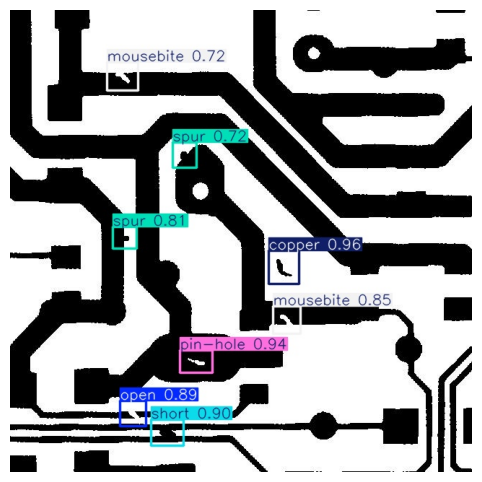

In [ ]:
import cv2
import matplotlib.pyplot as plt

# Obtener métricas de entrenamiento
metrics = model.val()


# Cargar la imagen con detecciones
img_detected = cv2.imread(output_image)
img_detected = cv2.cvtColor(img_detected, cv2.COLOR_BGR2RGB)  # Convertir a RGB

# Mostrar la imagen
plt.figure(figsize=(8, 6))
plt.imshow(img_detected)
plt.axis("off")
plt.show()


In [ ]:
from ultralytics import YOLO
import pandas as pd


# Extraer los valores en un diccionario
data = {
    "Precision": metrics.box.p.tolist(),
    "Recall": metrics.box.r.tolist(),
    "mAP50": metrics.box.map50.tolist(),
    "mAP50-95": metrics.box.map.tolist(),
}

# Crear un DataFrame
df = pd.DataFrame(data)

# Guardar en un archivo CSV
csv_path = "runs/detect/train4/custom_results.csv"
df.to_csv(csv_path, index=False)

print(f"✅ Métricas guardadas en {csv_path}")




Ultralytics 8.3.80 🚀 Python-3.11.11 torch-2.5.1+cu124 CUDA:0 (Tesla T4, 15095MiB)


val: Scanning /content/datasets/labels/val.cache... 601 images, 314 backgrounds, 0 corrupt: 100%|██████████| 601/601 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 38/38 [00:08<00:00,  4.43it/s]


                   all        601       1875      0.958      0.937      0.979      0.764
                  open        255        359      0.935      0.962      0.987      0.718
                 short        202        279       0.96       0.87      0.952      0.658
             mousebite        243        371      0.959      0.942      0.979      0.753
                  spur        237        327      0.968      0.924      0.981      0.742
                copper        219        253      0.957      0.976      0.992      0.875
              pin-hole        250        286      0.968      0.945      0.982      0.838
Speed: 1.8ms preprocess, 3.9ms inference, 0.0ms loss, 1.8ms postprocess per image
Results saved to runs/detect/train5
✅ Métricas guardadas en runs/detect/train4/custom_results.csv


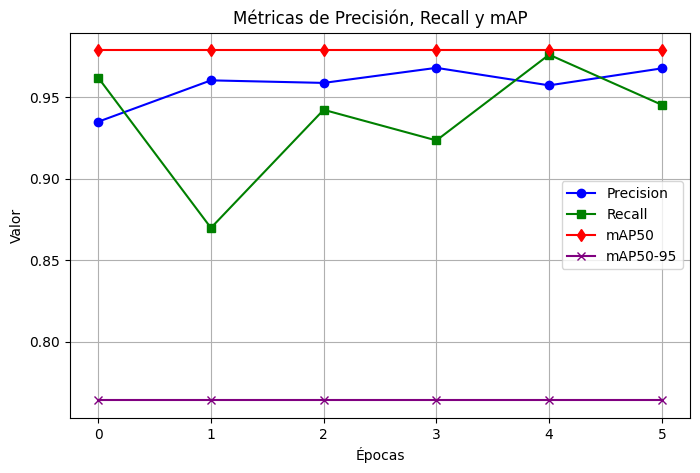

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo de métricas
csv_path = "runs/detect/train4/custom_results.csv"
df = pd.read_csv(csv_path)

# Graficar precisión, recall y mAP50-95
plt.figure(figsize=(8, 5))
plt.plot(df.index, df["Precision"], label="Precision", color="blue", marker="o")
plt.plot(df.index, df["Recall"], label="Recall", color="green", marker="s")
plt.plot(df.index, df["mAP50"], label="mAP50", color="red", marker="d")
plt.plot(df.index, df["mAP50-95"], label="mAP50-95", color="purple", marker="x")

plt.xlabel("Épocas")
plt.ylabel("Valor")
plt.title("Métricas de Precisión, Recall y mAP")
plt.legend()
plt.grid()
plt.show()
# Muestra cómo evolucionan la precisión, recall y mAP a lo largo del entrenamiento.

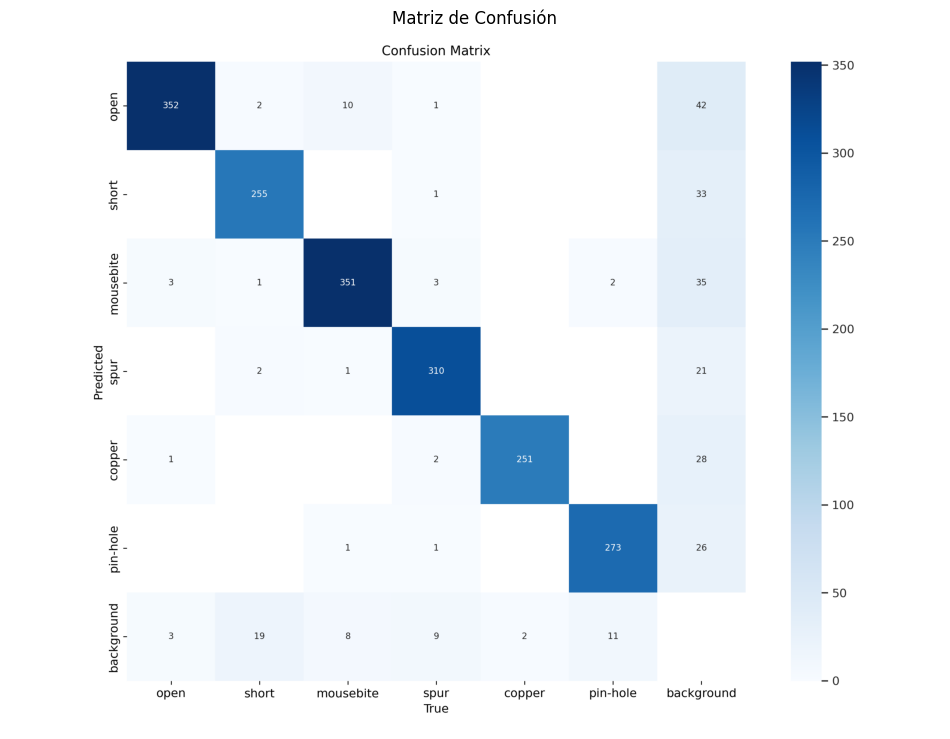

In [ ]:

import cv2
import matplotlib.pyplot as plt

# Ruta de la imagen de la matriz de confusión generada por YOLO
conf_matrix_path = "runs/detect/train4/confusion_matrix.png"

# Cargar y mostrar la imagen
img = cv2.imread(conf_matrix_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convertir de BGR a RGB

plt.figure(figsize=(12, 12))
plt.imshow(img)
plt.axis("off")
plt.title("Matriz de Confusión")
plt.show()
# Indica qué clases el modelo confunde con otras, mostrando errores de clasificación.


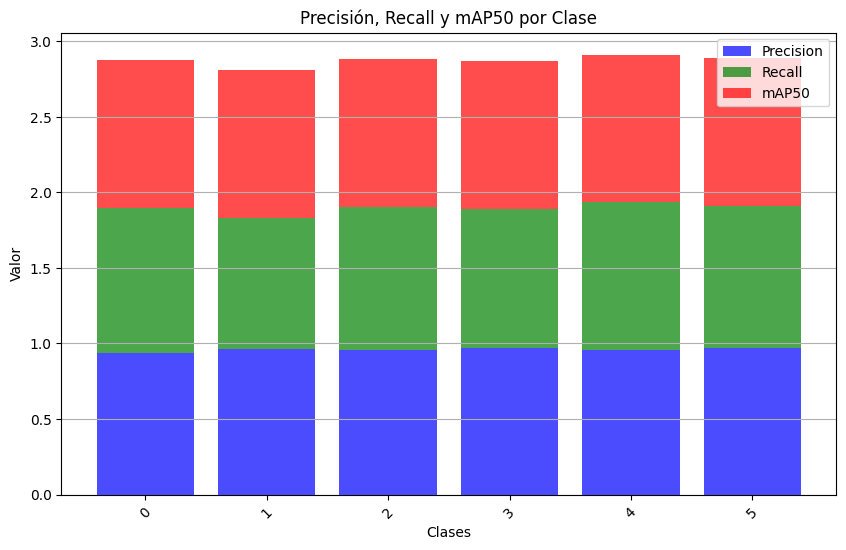

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt

# Cargar el archivo de métricas
csv_path = "runs/detect/train4/custom_results.csv"
df = pd.read_csv(csv_path)

# Crear un gráfico de barras para comparar métricas por clase
classes = df.index
precision = df["Precision"]
recall = df["Recall"]
map50 = df["mAP50"]

# Configurar el gráfico
plt.figure(figsize=(10, 6))
plt.bar(classes, precision, color="blue", alpha=0.7, label="Precision")
plt.bar(classes, recall, color="green", alpha=0.7, label="Recall", bottom=precision)
plt.bar(classes, map50, color="red", alpha=0.7, label="mAP50", bottom=[i + j for i, j in zip(precision, recall)])

plt.xlabel("Clases")
plt.ylabel("Valor")
plt.title("Precisión, Recall y mAP50 por Clase")
plt.xticks(rotation=45)
plt.legend()
plt.grid(axis="y")
plt.show()
# Compara la precisión, recall y mAP50 de cada clase para detectar las más problemáticas.

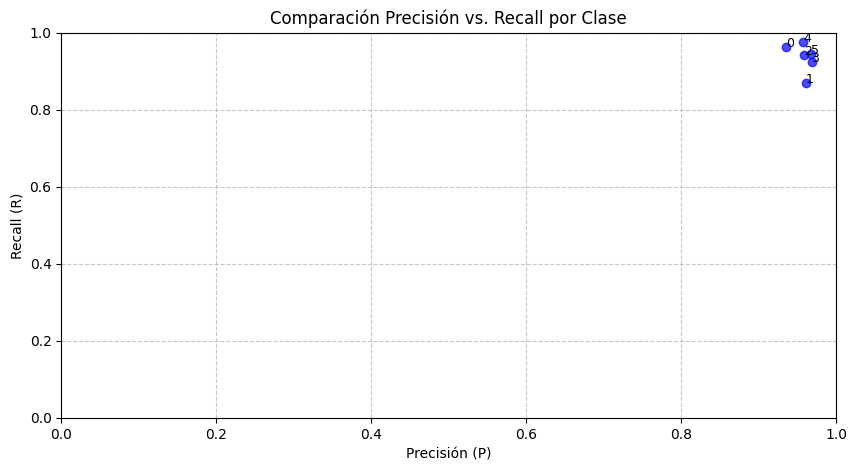

In [ ]:


# Graficar comparación de Precisión y Recall
plt.figure(figsize=(10, 5))
plt.scatter(df["Precision"], df["Recall"], color="blue", alpha=0.7)

for i, txt in enumerate(df.index):
    plt.annotate(txt, (df["Precision"][i], df["Recall"][i]), fontsize=9)

plt.xlabel("Precisión (P)")
plt.ylabel("Recall (R)")
plt.title("Comparación Precisión vs. Recall por Clase")
plt.xlim(0, 1)
plt.ylim(0, 1)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()
# Relaciona precisión y recall para cada clase, identificando problemas de falsos positivos o negativos.


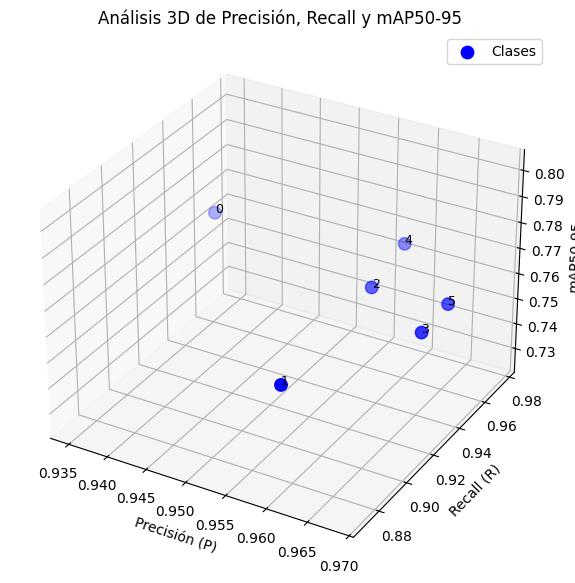

In [ ]:


import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Cargar el archivo de métricas
csv_path = "runs/detect/train4/custom_results.csv"
df = pd.read_csv(csv_path)

# Crear figura 3D
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection="3d")

# Datos para los ejes
x = df["Precision"]
y = df["Recall"]
z = df["mAP50-95"]
classes = df.index  # Nombres de las clases

# Graficar los puntos
ax.scatter(x, y, z, c="blue", marker="o", s=80, label="Clases")

# Etiquetas de los ejes
ax.set_xlabel("Precisión (P)")
ax.set_ylabel("Recall (R)")
ax.set_zlabel("mAP50-95")
ax.set_title("Análisis 3D de Precisión, Recall y mAP50-95")

# Agregar etiquetas de clase a los puntos
for i, txt in enumerate(classes):
    ax.text(x[i], y[i], z[i], txt, fontsize=9)

plt.legend()
plt.show()
# Visualiza en 3D el rendimiento de cada clase considerando las tres métricas clave.